# Fashion MNIST CNN Model
Uses Adam optimizer instead of SGD, adds batch normalization and dropout

In [24]:
# references: https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch

# load libraries
import torch
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# determine whether to use GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
# define variables for the model
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 25

## Data Preprocessing

In [26]:
# Normalize to [0, 1]
all_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))
])

# Load the training dataset
full_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=all_transforms)

# Load the testing dataset
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=all_transforms)

# Split into training and validation sets
validation_size = 10000
train_size = len(full_train_dataset) - validation_size
train_dataset, validation_dataset = random_split(full_train_dataset, [train_size, validation_size])

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Explore the Dataset

In [27]:
skip_cell = True

if not skip_cell:
  # Print basic information
  print("Training set size:", len(train_dataset))
  print("Validation set size:", len(validation_dataset))
  print("Test set size:", len(test_dataset))

  print("Image shape:", train_dataset[0][0].shape)
  print("Number of classes:", len(full_train_dataset.classes))

  #checking class balance.
  train_labels = [label for _, label in train_dataset]
  validation_labels = [label for _, label in validation_dataset]
  test_labels = [label for _, label in test_dataset]

  print("training label distribution:", torch.bincount(torch.tensor(train_labels)))
  print("validation label distribution:", torch.bincount(torch.tensor(validation_labels)))
  print("testing label distribution:", torch.bincount(torch.tensor(test_labels)))

In [28]:

if not skip_cell:
  # Get a batch of images from the training loader
  view_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
  images, labels = next(iter(view_loader))

  # Display images
  plt.figure(figsize=(10, 8))
  for i in range(16):
      plt.subplot(4, 4, i + 1)
      plt.imshow(images[i].squeeze(), cmap='gray')
      plt.title(full_train_dataset.classes[labels[i]])
      plt.axis('off')
  plt.show()

## Building Model

In [29]:
# Adds batch normalization after convolutional layers and dropout before fully connected layers
class ConvNet(nn.Module):
    # define layers and order in CNN
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128) # 64 channels, 7x7 feature map
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    # pass data across layers
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)  # Apply batch norm
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)  # Apply batch norm
        out = self.relu(out)
        out = self.pool1(out)

        out = self.conv3(out)
        out = self.bn3(out)  # Apply batch norm
        out = self.relu(out)
        out = self.conv4(out)
        out = self.bn4(out)  # Apply batch norm
        out = self.relu(out)
        out = self.pool2(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.dropout(out)  # Apply dropout
        out = self.relu(out)
        out = self.fc2(out)
        return out

## Setting Hyperparameters

In [30]:
model = ConvNet(num_classes).to(device)

# set loss function
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005) # use adam instead of SGD

total_step = len(train_loader)

## Training Model

In [31]:
# list to store loss/accuracy values for training/validation set
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0  # Accumulate training loss for the epoch
    train_correct = 0 # Number of correct training predictions
    train_total = 0 # Total number of training samples

    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Compute average training loss and accuracy for the epoch
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_loss_values.append(avg_train_loss)
    train_accuracy_values.append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute average validation loss and accuracy
    avg_val_loss = val_running_loss / len(validation_loader)
    val_accuracy = 100 * correct / total
    val_loss_values.append(avg_val_loss)
    val_accuracy_values.append(val_accuracy)

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Val Loss: {:.4f}, Val Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, avg_train_loss, train_accuracy, avg_val_loss, val_accuracy))

Epoch [1/25], Train Loss: 1.1192, Train Accuracy: 62.19%, Val Loss: 0.6368, Val Accuracy: 76.05%
Epoch [2/25], Train Loss: 0.5624, Train Accuracy: 79.22%, Val Loss: 0.5933, Val Accuracy: 77.60%
Epoch [3/25], Train Loss: 0.4769, Train Accuracy: 82.64%, Val Loss: 0.4619, Val Accuracy: 83.08%
Epoch [4/25], Train Loss: 0.4257, Train Accuracy: 84.62%, Val Loss: 0.4171, Val Accuracy: 84.83%
Epoch [5/25], Train Loss: 0.3921, Train Accuracy: 85.94%, Val Loss: 0.4058, Val Accuracy: 85.07%
Epoch [6/25], Train Loss: 0.3717, Train Accuracy: 86.72%, Val Loss: 0.3809, Val Accuracy: 85.87%
Epoch [7/25], Train Loss: 0.3586, Train Accuracy: 87.10%, Val Loss: 0.3943, Val Accuracy: 84.95%
Epoch [8/25], Train Loss: 0.3441, Train Accuracy: 87.47%, Val Loss: 0.3890, Val Accuracy: 85.42%
Epoch [9/25], Train Loss: 0.3312, Train Accuracy: 87.98%, Val Loss: 0.3517, Val Accuracy: 87.08%
Epoch [10/25], Train Loss: 0.3217, Train Accuracy: 88.45%, Val Loss: 0.3446, Val Accuracy: 87.50%
Epoch [11/25], Train Loss: 0.

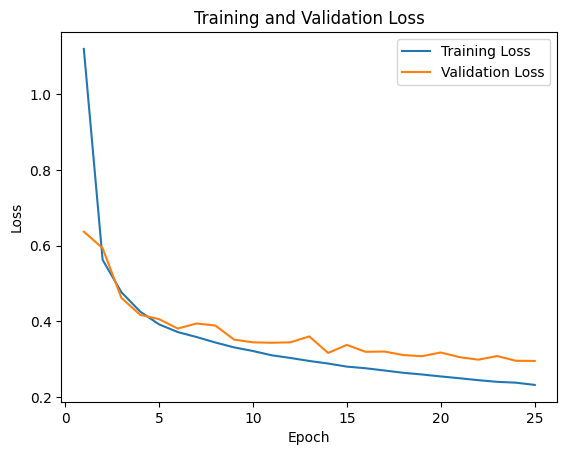

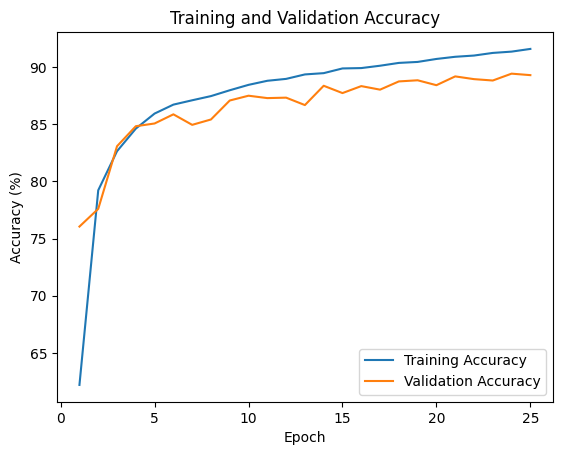

In [32]:
# Plotting Loss
plt.figure()
plt.plot(range(1, num_epochs + 1), train_loss_values, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting Accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracy_values, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Evaluating Model on Test Dataset

In [33]:
# compute test accuracy
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} test images: {:.2f} %'.format(len(test_dataset), 100 * correct / total))

Accuracy of the network on the 10000 test images: 89.48 %


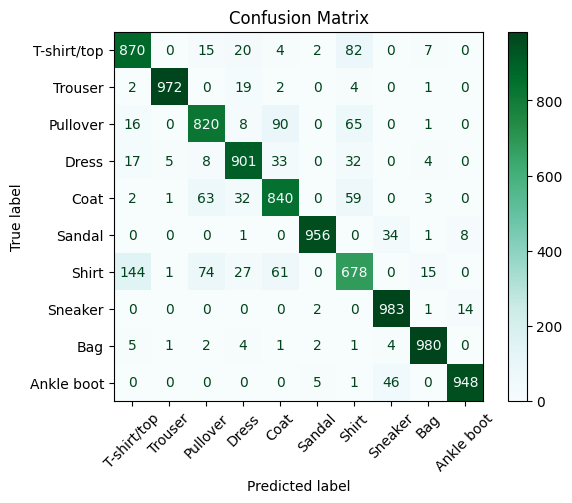

In [34]:
# Collect true and predicted labels
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix with adjustments
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_train_dataset.classes)
disp.plot(cmap='BuGn', ax=ax)
plt.title('Confusion Matrix')
plt.xticks(rotation=45)  # Rotate x-axis labels to prevent overlap
plt.show()